In [1]:
import sys
sys.path.append("../src")

from jacks_amr import amr
import jax.numpy as jnp
import jax
import equinox as eqx
import matplotlib.pyplot as plt
import matplotlib as mpl
import timeit

from jacks_amr.flux_divergence import flux_divergence
from jacks_amr.refinement import refine_grid_for_function
from jacks_amr.indicators import approximate_gradient_indicator

In [2]:
n_levels = 5

L0_shape = (60,)

level_specs = [amr.AMRLevelSpec(0, L0_shape, 1, (60,))] + [
    amr.AMRLevelSpec(i, L0_shape, min(80, 9*(2**i)), (2,)) for i in range(1, 5)
]

AMR = amr.AMRGridFactory(5, 1, L0_shape,
                         (0.,), (2. * jnp.pi,), level_specs)

def f_init(x):
    return jnp.sin(x) + 0.1


def flux(q_in, q_out, normal):
    F = 0.5 * (q_in**2 + q_out**2)
    jump = (q_out - q_in)
    return F - 0.5 * jnp.maximum(jnp.abs(q_out), jnp.abs(q_in)) * jump

copyout_bcs = lambda coords, copyout_values: copyout_values

coords: (Array(2, dtype=int32),)
coords: (Array(2, dtype=int32),)
coords: (Array(2, dtype=int32),)
coords: (Array(2, dtype=int32),)
vmapped: (Array(80, dtype=int32), Array(2, dtype=int32))
vmapped: (Array(72, dtype=int32), Array(2, dtype=int32))
vmapped: (Array(36, dtype=int32), Array(2, dtype=int32))
vmapped: (Array(18, dtype=int32), Array(2, dtype=int32))
coords: (Array(60, dtype=int32),)
vmapped: (Array(1, dtype=int32), Array(60, dtype=int32))


ValueError: Arguments to jax.numpy.ix_ must be 1-dimensional, got shape ()

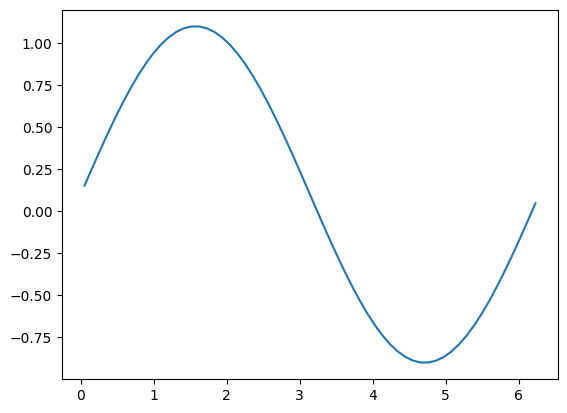